In [ ]:
!pip install fastembed
!pip install qdrant-client
!pip install langgraph langchain
!pip install langchain-google-genai

In [ ]:
!pip install opik
!pip install ragas
!pip install grandalf

In [ ]:
import os
from google.colab import userdata

In [ ]:
from qdrant_client import QdrantClient,models
from qdrant_client.http.models import Distance, VectorParams, SparseVectorParams
from qdrant_client.models import PointStruct
from fastembed import TextEmbedding, SparseTextEmbedding

from langgraph.graph import StateGraph
from langgraph.graph import START,END
from typing import TypedDict, List,Dict,Optional,Any
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
dense_embedding_model = TextEmbedding(model_name="jinaai/jina-embeddings-v2-base-en")
sparse_embedding_model = SparseTextEmbedding("Qdrant/BM25")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

onnx/model.onnx:   0%|          | 0.00/547M [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

danish.txt:   0%|          | 0.00/424 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

dutch.txt:   0%|          | 0.00/453 [00:00<?, ?B/s]

arabic.txt: 0.00B [00:00, ?B/s]

english.txt:   0%|          | 0.00/936 [00:00<?, ?B/s]

hungarian.txt: 0.00B [00:00, ?B/s]

french.txt:   0%|          | 0.00/813 [00:00<?, ?B/s]

norwegian.txt:   0%|          | 0.00/851 [00:00<?, ?B/s]

finnish.txt: 0.00B [00:00, ?B/s]

greek.txt: 0.00B [00:00, ?B/s]

italian.txt: 0.00B [00:00, ?B/s]

german.txt: 0.00B [00:00, ?B/s]

portuguese.txt: 0.00B [00:00, ?B/s]

russian.txt: 0.00B [00:00, ?B/s]

romanian.txt: 0.00B [00:00, ?B/s]

spanish.txt: 0.00B [00:00, ?B/s]

turkish.txt:   0%|          | 0.00/260 [00:00<?, ?B/s]

swedish.txt:   0%|          | 0.00/559 [00:00<?, ?B/s]

In [ ]:
url = userdata.get("QDRANT_URL")
api_key = userdata.get("QDRANT_API_KEY")
os.environ['GOOGLE_API_KEY'] = userdata.get("GOOGLE_API_KEY")
collection_name = "hybrid"

In [ ]:
client = QdrantClient(
    url = url,
    api_key=api_key,
)

## LLM-as-a-Judge

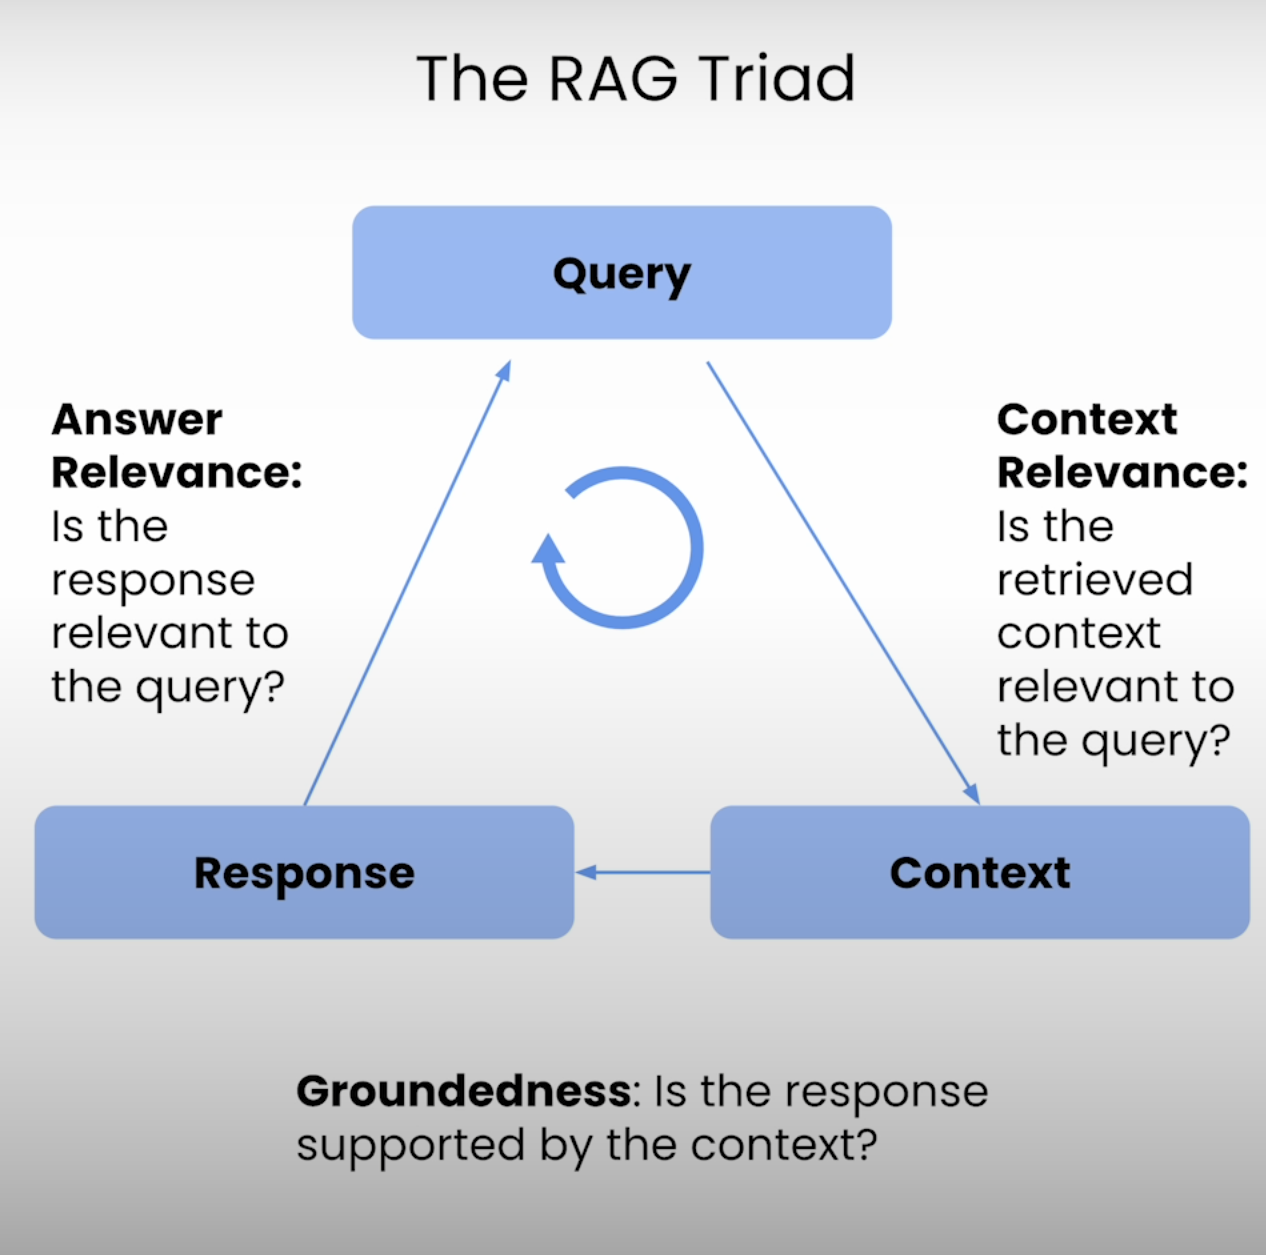

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
                                temperature=0.0,max_tokens=None)

## LangGraph - Parallel Node

In [ ]:
class RAGState(TypedDict):
    query: str
    context: List[str]
    answer: str
    answer_relevance: str
    context_relevance: str

## Context Relevance (C|Q)

In [ ]:
def get_context_relevance(state: RAGState):
  instuctions = """You are a teacher grading a quiz.
  You will be given a QUESTION and a set of FACTS provided by the student.

  Here is the grade criteria to follow:

  <criteria>
  (1) You goal is to identify FACTS that are completely unrelated to the QUESTION
  (2) If the facts contain ANY keywords or semantic meaning related to the question, consider them relevant
  (3) It is OK if the facts have SOME information that is unrelated to the question as long as (2) is met
  </criteria>

  <instructions>
  Relevance:
  A relevance value of True means that the FACTS contain ANY keywords or semantic meaning related to the QUESTION and are therefore relevant.
  A relevance value of False means that the FACTS are completely unrelated to the QUESTION.
  Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.
  Avoid simply stating the correct answer at the outset.
  </instructions>
  """

  relevant_document = "\n\n".join(state['context'])
  user_prompt = f"FACTS: {relevant_document}\nQUESTION: {state['query']}"

  prompt = [
        {"role": "system", "content": instuctions},
        {"role": "user", "content": user_prompt},
    ]
  grade = llm.invoke(prompt)
  return {"context_relevance":grade.content}

### Answer Relevance (A|Q)

In [ ]:
def get_answer_relevance(state: RAGState):
  instuctions = """You are a teacher grading a quiz.
    You will be given a QUESTION and a STUDENT ANSWER.

    <criteria>
    Here is the grade criteria to follow:
    (1) Ensure the STUDENT ANSWER is concise and relevant to the QUESTION
    (2) Ensure the STUDENT ANSWER helps to answer the QUESTION
    </criteria>

    <instructions>
    Relevance:
    A relevance value of True means that the student's answer meets all of the criteria.
    A relevance value of False means that the student's answer does not meet all of the criteria.
    Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.
    Avoid simply stating the correct answer at the outset.
    </instructions>
  """

  eval_setup = f"QUESTION: {state['query']}\nSTUDENT ANSWER: {state['answer']}"
  prompt = [
        {"role": "system", "content": instuctions},
        {"role": "user", "content": eval_setup},
    ]
  grade = llm.invoke(prompt)

  return {"answer_relevance":grade.content}

In [ ]:
def search(state: RAGState):
  dense_vectors = next(dense_embedding_model.query_embed(state['query']))
  sparse_vectors = next(sparse_embedding_model.query_embed(state['query']))

  prefetch = [
    models.Prefetch(
        query = dense_vectors,
        using = "dense", # vector search
        limit = 15
    ),
    models.Prefetch(
        query = models.SparseVector(**sparse_vectors.as_object()),
        using = "sparse",
        limit = 15
    )]


  relevant_docs = client.query_points(
    collection_name = collection_name,
    prefetch = prefetch,
    query = dense_vectors,
    using = "dense",
    with_payload=True,
    limit = 3,
    )

  context = [] # List[str]
  for info in relevant_docs.points:
    context.append(info.payload['document'])

  return {"context":context}

In [ ]:
def answer(state: RAGState) -> RAGState:
    context = " ".join(state['context'])

    prompt = f"""You are an seasoned support staff working at Atyantik, based on the given CONTEXT as the only source of information answer the user QUESTION.
    If user QUESTION is not from the CONTEXT, just say: I dont know , not enough information provided

    <context>
    CONTEXT: {context}
    </context
    <question>
    Question: {state['query']}
    </question>
    """
    answer = llm.invoke(prompt)

    return {"answer":answer.content}

In [ ]:
def join_nodes(state):
  return state

def parallel_nodes(state):
  return ['get_context_relevance','get_answer_relevance']

In [ ]:
workflow = StateGraph(RAGState)

workflow.add_node("search_context",search)
workflow.add_node("answer_generation",answer)
workflow.add_node("get_context_relevance",get_context_relevance)
workflow.add_node("get_answer_relevance",get_answer_relevance)
workflow.add_node("join_nodes",join_nodes)

workflow.add_edge(START,"search_context")
workflow.add_edge("search_context","answer_generation")
workflow.add_conditional_edges(
    "answer_generation",
    parallel_nodes,
    {
        "get_context_relevance": "get_context_relevance",
        "get_answer_relevance": "get_answer_relevance"
    }
)
workflow.add_edge("get_context_relevance","join_nodes")
workflow.add_edge("get_answer_relevance","join_nodes")
workflow.add_edge("join_nodes",END)

## Documentation for Graph API, reference for creating different edges:
[https://langchain-ai.github.io/langgraph/how-tos/graph-api/#create-and-control-loops](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#create-and-control-loops)

Example workflows:

- Human-in-a-loop
- Parallel node execution
- Routing System:

In [ ]:
graph = workflow.compile()

In [ ]:
graph.get_graph().print_ascii()

                       +-----------+                          
                       | __start__ |                          
                       +-----------+                          
                              *                               
                              *                               
                              *                               
                     +----------------+                       
                     | search_context |                       
                     +----------------+                       
                              *                               
                              *                               
                              *                               
                   +-------------------+                      
                   | answer_generation |                      
                   +-------------------+                      
                    ...               ...              

In [ ]:
response = graph.invoke({"query":"what is the mail to contact atyantik"})

In [ ]:
response['answer']

'The mail to contact Atyantik is contact@atyantik.com.'

In [ ]:
response['context_relevance']

'Relevance: True\n\nReasoning:\n1. The QUESTION asks "what is the mail to contact atyantik". This is asking for an email address to contact the company "Atyantik".\n2. The FACTS provided contain a section with contact information.\n3. Within this contact information, the email address "contact@atyantik.com" is explicitly listed.\n4. The keyword "contact" from the question is directly present in the facts, and "mail" is semantically related to an email address.\n5. Therefore, the facts contain direct and semantically relevant information to answer the question.'

In [ ]:
response['answer']

'Atyantik uses a self-built framework.'

## Metric Based

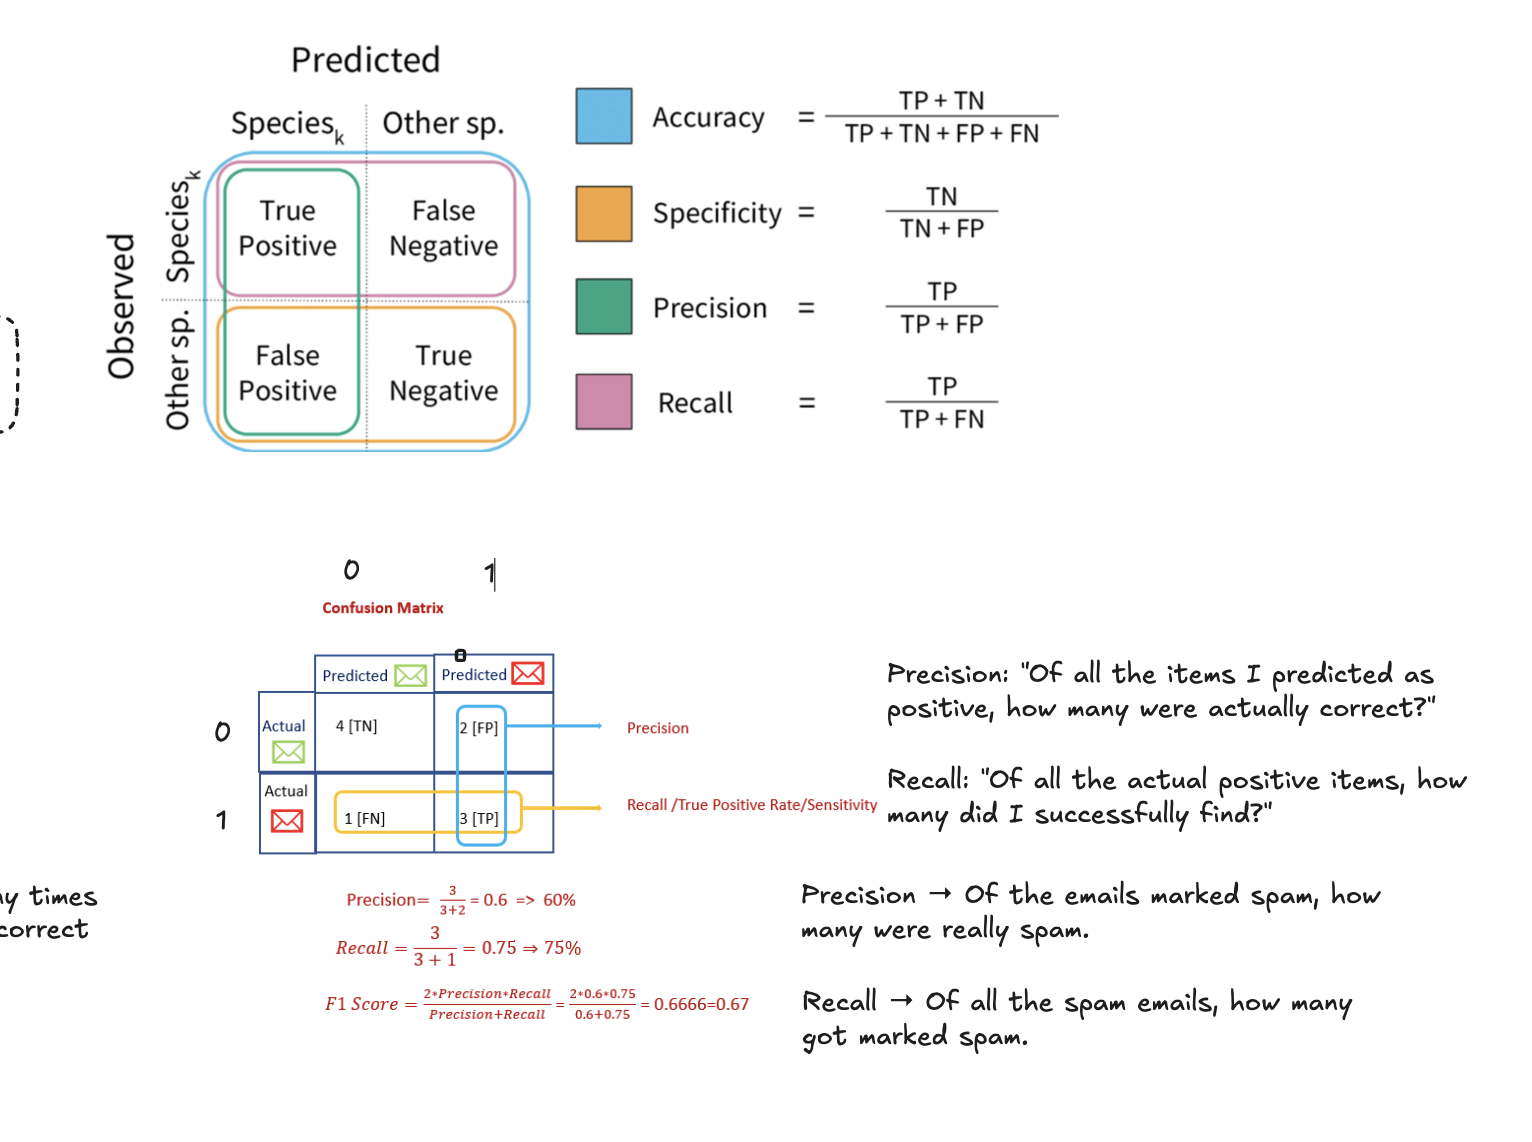

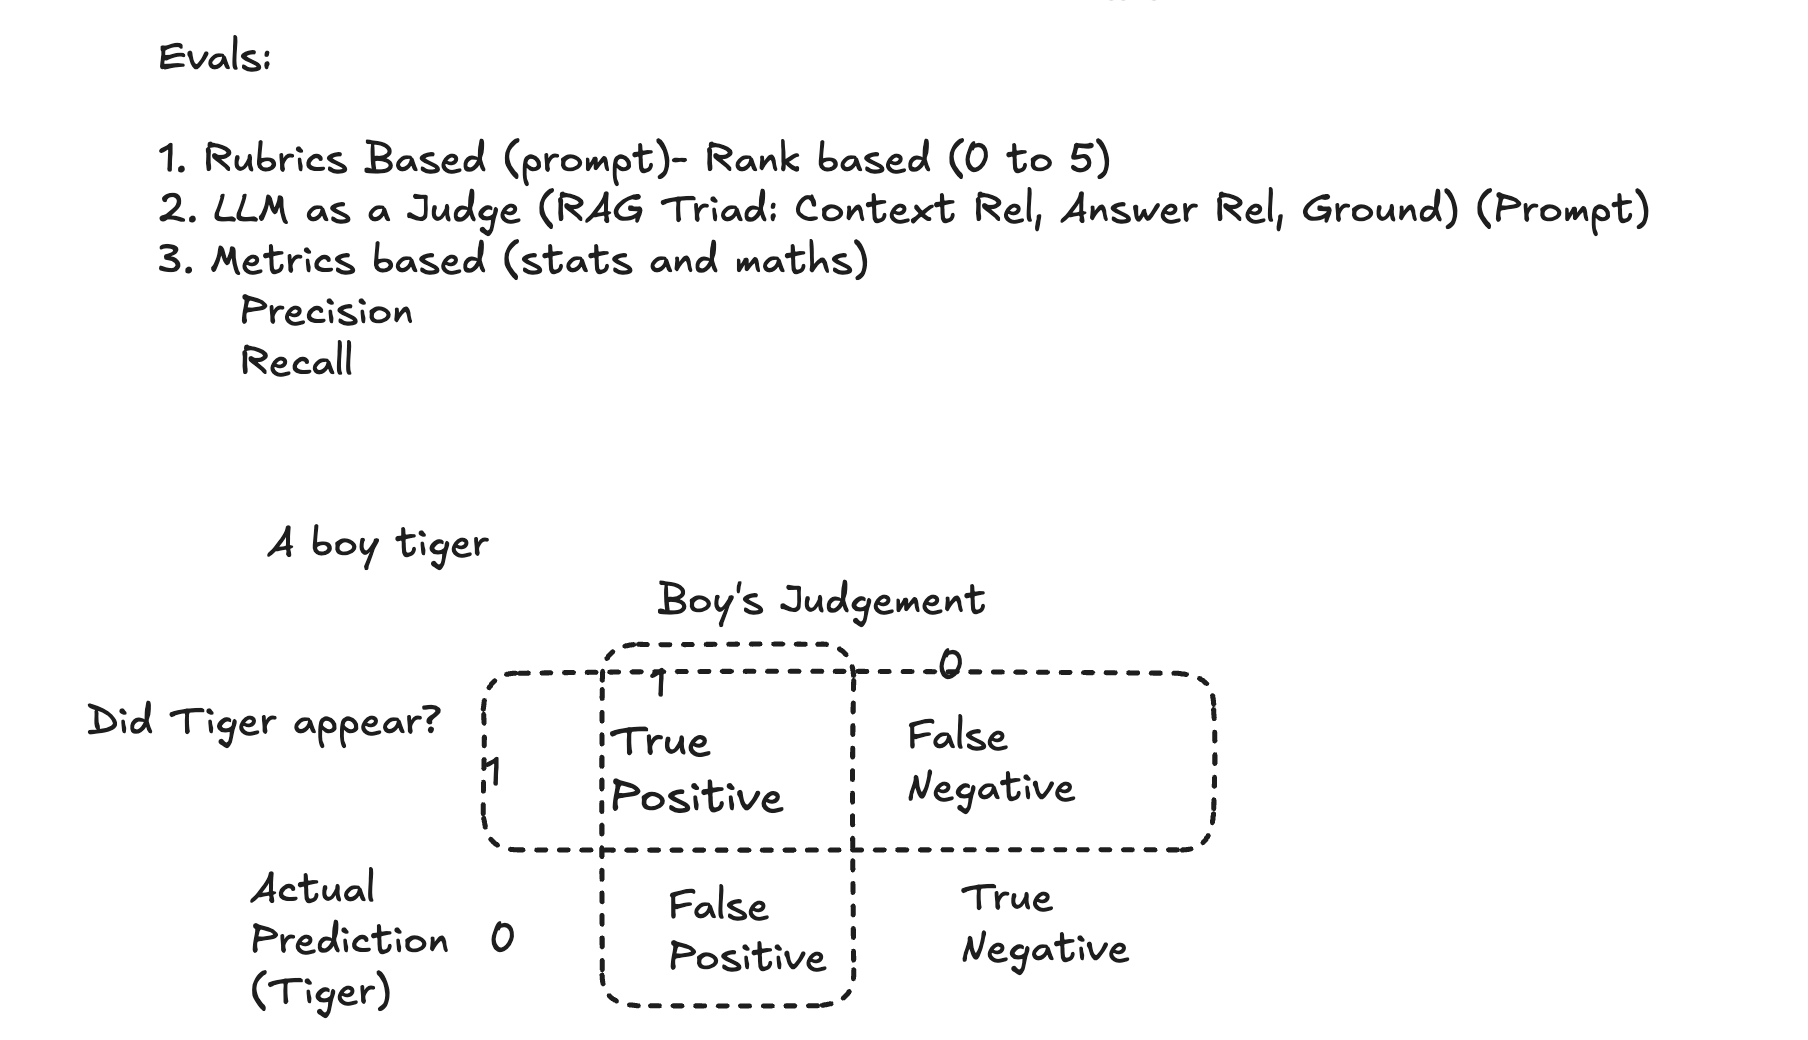

- Answer Relevance (A|Q)
- Context Relevance (C|Q)
- Groundness/Faithfullness (A|C)

In [ ]:
# single Turn
# multi turn
# default LLM: OpenAI
from ragas.dataset_schema import SingleTurnSample
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import Faithfulness,LLMContextPrecisionWithoutReference

In [ ]:
eval_llm = LangchainLLMWrapper(llm) # ragas

In [ ]:
single_turn = SingleTurnSample(
    user_input = response['query'],
    response = response['answer'],
    retrieved_contexts = response['context']
)

### Faithfulness

The Faithfulness metric measures how factually consistent a response (A) is with the retrieved context (C). It ranges from 0 to 1, with higher scores indicating better consistency.

In [ ]:
faithful = Faithfulness(llm=eval_llm) # openai

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
scores = await faithful.single_turn_ascore(single_turn)

In [ ]:
type(scores)

float

## Context Precision

Context Precision is a metric that evaluates the retriever’s ability to rank relevant chunks higher than irrelevant ones for a given query in the retrieved context. Specifically, it assesses the degree to which relevant chunks in the retrieved context are placed at the top of the ranking.

It is calculated as the mean of the precision@k for each chunk in the context. Precision@k is the ratio of the number of relevant chunks at rank k to the total number of chunks at rank k.

In [ ]:
from opik import track, opik_context

In [ ]:
os.environ['OPIK_API_KEY'] = userdata.get("OPIK_API_KEY")
os.environ['OPIK_WORKSPACE'] = "tarun-r-jain"
os.environ['OPIK_PROJECT_NAME'] = "atyantik"

In [ ]:
@track(name="precision")
async def get_context_precision_at_k2(response):
  single_turn = SingleTurnSample(
    user_input = response['query'],
    response = response['answer'],
    retrieved_contexts = [response['context'][1]]
  )
  context_precision = LLMContextPrecisionWithoutReference(llm=eval_llm)
  scores = await context_precision.single_turn_ascore(single_turn)

  opik_context.update_current_trace(
      feedback_scores = [
          {"name": "Context Precision-k1","value":scores,"reason": response['answer']}
      ]
  )
  return scores

In [ ]:
await get_context_precision_at_k2(response)

0.0

## Generate Synthetic Dataset and Run Evals on Batches

In [ ]:
!pip install langchain-openai

In [ ]:
from langchain_community.document_loaders import WebBaseLoader

In [ ]:
urls = [
    "https://atyantik.com/",
    "https://atyantik.com/about-us/",
]

In [ ]:
documents = WebBaseLoader(urls).load() # len(documents) = 2

### Dataset creation

In [ ]:
from ragas.testset import TestsetGenerator # LLM within it.
# 1. Diverse
# 2. Different Scenarios (single turn, multiple turn, no answer, invalid, negative edge)
# 3. Different Personas (tech, non tech, expert, )
from ragas.testset.persona import Persona
from ragas.testset.synthesizers.single_hop.specific import SingleHopSpecificQuerySynthesizer
# Single Hop or Multi Hop

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import OpenAIEmbeddings

from langchain_openai import ChatOpenAI
import openai

In [ ]:
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
openai_client = openai.OpenAI() # api key
evaluator_embeddings = OpenAIEmbeddings(client=openai_client)

In [ ]:
eval_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.1,
) # langchain

In [ ]:
evaluator_llm = LangchainLLMWrapper(eval_llm)

In [ ]:
personas = [
    Persona(
        name="Expert Software Assistant",
        role_description="A seasoned software developer with solid foundation in SaaS and customer service assistant",
    )
]

In [ ]:
from ragas.testset.transforms.extractors.llm_based import NERExtractor
from ragas.testset.transforms.splitters import HeadlineSplitter

# NER: Named Entitiy Recognition: Name, Organization, Geo-political, Location
transforms = [HeadlineSplitter(), NERExtractor()] # NERExtractor() - will happen by default

In [ ]:
generator = TestsetGenerator(
    embedding_model=evaluator_embeddings, persona_list=personas
)

In [ ]:
distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=evaluator_llm), 0.7,0.3),
]

In [ ]:
dataset = generator.generate_with_langchain_docs(
    documents,
    testset_size=5,
    transforms=transforms,
    query_distribution=distribution,
)

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
dataset.to_pandas()

,user_input,reference_contexts,response,reference,synthesizer_name
0,What WaveRFID do?,[\n\n\n\n\n\n\n\n\n\n\n\nSoftware Development ...,Answer,WaveRFID is a cloud-based SaaS platform for in...,single_hop_specific_query_synthesizer
1,What services does Atyantik offer in Gujarat?,[\n\n\n\n\n\n\n\n\n\n\n\nSoftware Development ...,NaN,"Atyantik, located in Vadodara, Gujarat, offers...",single_hop_specific_query_synthesizer
2,What services does Atyantik offer in Vadodara?,[\n\n\n\n\n\n\n\n\n\n\n\nSoftware Development ...,NaN,"Atyantik, located in Vadodara, Gujarat, offers...",single_hop_specific_query_synthesizer
3,What role did Atyantik play in bringing Luxe G...,[\n\n\n\n\n\n\n\n\n\n\n\n\nAbout Atyantik - Pr...,NaN,Atyantik played a crucial role in bringing Lux...,single_hop_specific_query_synthesizer
4,How did Atyantik contribute to the success of ...,[\n\n\n\n\n\n\n\n\n\n\n\n\nAbout Atyantik - Pr...,NaN,Gary Delosa from FoxDealer praised Atyantik fo...,single_hop_specific_query_synthesizer
5,Wher is Atyantik located in Vadodara?,[\n\n\n\n\n\n\n\n\n\n\n\n\nAbout Atyantik - Pr...,NaN,"Atyantik is located at 501, Privilege Avenue, ...",single_hop_specific_query_synthesizer


when you create the dataset:
- reference context (actual context)
- user input (prompt/ user queries generated by LLM)
- reference (actual response)

Evals: Against the model answer and the dataset

- response
- retrieved_context

In [ ]:
dataset.samples[0].eval_sample

In [ ]:
print(dataset.samples[1].eval_sample.retrieved_contexts)

None


In [ ]:
dataset.samples[2].eval_sample.response

None


In [ ]:
print(dataset.samples[1].eval_sample.user_input)

What services does Atyantik offer in Gujarat?


In [ ]:
print(len(dataset.samples[1].eval_sample.reference_contexts))

1


In [ ]:
for data in dataset:
  print(data)

eval_sample=SingleTurnSample(user_input='What WaveRFID do?', retrieved_contexts=None, reference_contexts=["\n\n\n\n\n\n\n\n\n\n\n\nSoftware Development Company in Vadodara, Gujarat | Atyantik\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to content\n\n\n\n\n \n\nAbout Us\n\nAbout Us\nTeam\nCorporate Partnership\nTechnologies\n\n\nServices\n\nDesign\n\nUX & UI design\nLanding page\n\n\nHire Talent\n\nHire Dedicated Designers\nHire Dedicated Developers\n\n\nDevelopment\n\nSoftware Development\nSaaS Development\nMVP\nPWA app development\nEcommerce solutions\nEnterprise app\nCRM solutions\nERP development\nCMS development\n\n\nGrowth\n\nSearch Engine Optimisation\n\n\nConsulting\n\nSearch Engine Optimisation\nOur Approach\n\n\n\n\nProjects\nBlogs\nCareers\n\nJobs\nCareers\n\n\nPartnership\n \n\n\nContact Us\n\n\n\n\n\nDiscuss your project\n\n\n\n\n\n\nScalable Cloud and SaaS for Rapid Growth\

In [ ]:
workflow = StateGraph(RAGState)

workflow.add_node("search_context",search)
workflow.add_node("answer_generation",answer)

workflow.add_edge(START,"search_context")
workflow.add_edge("search_context","answer_generation")
workflow.add_edge("answer_generation",END)

graph = workflow.compile()

In [ ]:
def get_rag_response(dataset):
  for data in dataset:
    query = data.eval_sample.user_input
    response = graph.invoke({"query":query})
    # response['query'] response['answer]
    data.eval_sample.response = response['answer']
    data.eval_sample.retrieved_contexts = response['context']

In [ ]:
get_rag_response(dataset)

In [ ]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What WaveRFID do?,[We want to thank the entire Atyantik team; be...,[\n\n\n\n\n\n\n\n\n\n\n\nSoftware Development ...,WAVE RFID provides the best optical inventory ...,WaveRFID is a cloud-based SaaS platform for in...,single_hop_specific_query_synthesizer
1,What services does Atyantik offer in Gujarat?,[Atyantik is a team of techno enthusiasts with...,[\n\n\n\n\n\n\n\n\n\n\n\nSoftware Development ...,Atyantik offers the following services:\n\n**D...,"Atyantik, located in Vadodara, Gujarat, offers...",single_hop_specific_query_synthesizer
2,What services does Atyantik offer in Vadodara?,[Atyantik is a team of techno enthusiasts with...,[\n\n\n\n\n\n\n\n\n\n\n\nSoftware Development ...,Atyantik offers the following services:\n\n**D...,"Atyantik, located in Vadodara, Gujarat, offers...",single_hop_specific_query_synthesizer
3,What role did Atyantik play in bringing Luxe G...,[I have been working with the Atyantik team fo...,[\n\n\n\n\n\n\n\n\n\n\n\n\nAbout Atyantik - Pr...,Atyantik took the idea for Luxe Global and bro...,Atyantik played a crucial role in bringing Lux...,single_hop_specific_query_synthesizer
4,How did Atyantik contribute to the success of ...,[We want to thank the entire Atyantik team; be...,[\n\n\n\n\n\n\n\n\n\n\n\n\nAbout Atyantik - Pr...,"According to Gary Delosa, Atyantik contributed...",Gary Delosa from FoxDealer praised Atyantik fo...,single_hop_specific_query_synthesizer
5,Wher is Atyantik located in Vadodara?,[Atyantik is a team of techno enthusiasts with...,[\n\n\n\n\n\n\n\n\n\n\n\n\nAbout Atyantik - Pr...,"Atyantik is located at 501, Privilege Avenue, ...","Atyantik is located at 501, Privilege Avenue, ...",single_hop_specific_query_synthesizer


In [ ]:
from ragas import evaluate
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness

In [ ]:
eval_dataset = dataset.to_evaluation_dataset()

In [ ]:
eval_dataset

EvaluationDataset(features=['user_input', 'retrieved_contexts', 'reference_contexts', 'response', 'reference'], len=6)

In [ ]:
result = evaluate(
    dataset = eval_dataset,
    metrics=[
        Faithfulness(),
        FactualCorrectness(),
        LLMContextRecall(),
        LLMContextPrecisionWithoutReference(),
    ],
    llm = evaluator_llm
)

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
result

{'faithfulness': 0.6667, 'factual_correctness(mode=f1)': 0.7533, 'context_recall': 0.6944}